<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/02_ROCKET_a_new_SOTA_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to introduce you to Rocket. 

ROCKET (RandOm Convolutional KErnel Transform) is a new Time Series Classification (TSC) method that has just been released (Oct 29th, 2019), and has achieved **state-of-the-art performance on the UCR univariate time series classification datasets, surpassing HIVE-COTE (the previous state of the art since 2017) in accuracy, with exceptional speed compared to other traditional DL methods.** 

To achieve these 2 things at once is **VERY IMPRESSIVE**. ROCKET is certainly a new TSC method you should try.

Authors:
Dempster, A., Petitjean, F., & Webb, G. I. (2019). ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels. arXiv preprint arXiv:1910.13051.

[paper](https://arxiv.org/pdf/1910.13051)

There are 2 main limitations to the original ROCKET method though:
- Released code doesn't handle multivariate data
- It doesn't run on a GPU, so it's slow when used with a large datasets

In this notebook you will learn: 
- how you can use the original ROCKET method
- you will also learn about a new ROCKET version I have developed in Pytorch, that handles both **univariate and multivariate** data, and uses **GPU**
- you will see how you can integrate the ROCKET features with fastai or other classifiers

## Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
computer_setup()

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.0+cu101


## How to use the original ROCKET method? 🚀

ROCKET is applied in 2 phases:

1. Generate features from each time series: ROCKET calculates 20k features from each time series, independently of the sequence length. 
2. Apply a classifier to those calculated features. Those features are then used by the classifier of your choice. In the original code they use 2 simple linear classifiers: RidgeClassifierCV and Logistic Regression, but you can use any classifier.

### 1️⃣ Generate features

Let's first generate the features. We'll import data from a UCR Time Series dataset.

The original method requires the time series to be in a 2d array of shape (samples, len). Remember than only univariate sequences are allow in this original method.

In [ ]:
X_train, y_train, X_valid, y_valid = get_UCR_data('OliveOil')
seq_len = X_train.shape[-1]
X_train = X_train[:, 0]
X_valid = X_valid[:, 0]
labels = np.unique(y_train)
transform = {}
for i, l in enumerate(labels): transform[l] = i
y_train = np.vectorize(transform.get)(y_train)
y_valid = np.vectorize(transform.get)(y_valid)

Now we normalize the data to mean 0 and std 1 **'per sample'** (recommended by the authors), that is they set each sample to mean 0 and std 1).

In [ ]:
X_train = (X_train - X_train.mean(axis = 1, keepdims = True)) / (X_train.std(axis = 1, keepdims = True) + 1e-8)
X_valid = (X_valid - X_valid.mean(axis = 1, keepdims = True)) / (X_valid.std(axis = 1, keepdims = True) + 1e-8)
X_train.mean(axis = 1, keepdims = True).shape

(30, 1)

To generate the features, we first need to create the 10k random kernels that will be used to process the data.

In [ ]:
kernels = generate_kernels(seq_len, 10000)

Now we apply those random kernels to the data

In [ ]:
X_train_tfm = apply_kernels(X_train, kernels)
X_valid_tfm = apply_kernels(X_valid, kernels)

### 2️⃣ Apply a classifier

So now we have the features, and we are ready to apply a classifier. 

Let's use a simple, linear RidgeClassifierCV as they propose in the paper. We first instantiate it. 

Note:
alphas: Array of alpha values to try. Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization. Alpha corresponds to C^-1 in other linear models such as LogisticRegression or LinearSVC.

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)

In [ ]:
 classifier.fit(X_train_tfm, y_train)

RidgeClassifierCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                  normalize=True)

In [ ]:
classifier.score(X_valid_tfm, y_valid)

0.9333333333333333

☣️ **This is pretty impressive! It matches or exceeds the state-of-the-art performance without any fine tuning in <2 seconds!!!**

In [ ]:
kernels = generate_kernels(seq_len, 10000)
X_train_tfm = apply_kernels(X_train, kernels)
X_valid_tfm = apply_kernels(X_valid, kernels)
from sklearn.linear_model import RidgeClassifierCV
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
classifier.fit(X_train_tfm, y_train)
classifier.score(X_valid_tfm, y_valid)

0.9

⚠️ Bear in mind that this process is not deterministic since there is randomness involved in the kernels. In thiis case, performance may vary between .9 to .933

## How to use ROCKET with large and/ or multivariate datasets on GPU? - Recommended ⭐️

As stated before, the current ROCKET method doesn't support multivariate time series or GPU. This may be a drawback in some cases. 

To overcome both limitations I've created a multivariate ROCKET on GPU in Pytorch. 

### 1️⃣ Generate features

First you prepare the input data and normalize it per sample. The input to ROCKET Pytorch is a 3d tensor of shape (samples, vars, len), preferrable on gpu.

The way to use ROCKET in Pytorch is the following:

* Create a dataset as you would normally do in `tsai`. 
* Create a TSDataLoaders with the following kwargs: 
    * drop_last=False. In this way we get features for every input sample.
    * shuffle_train=False
    * batch_tfms=[TSStandardize(by_sample=True)] so that input is normalized by sample, as recommended by the authors


In [ ]:
X, y, splits = get_UCR_data('HandMovementDirection', split_data=False)
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, drop_last=False, shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)

☣️☣️ You will be able to create a dls (TSDataLoaders) object with unusually large batch sizes. I've tested it with a large dataset and a batch size = 100_000 and it worked fine. This is because ROCKET is not a usual Deep Learning model. It just applies convolutions (kernels) one at a time to create the features.

Instantiate a rocket model with the desired n_kernels (authors use 10_000) and kernel sizes (7, 9 and 11 in the original paper). 

In [ ]:
model = build_ts_model(ROCKET, dls=dls) # n_kernels=10_000, kss=[7, 9, 11] set by default, but you can pass other values as kwargs

Now generate rocket features for the entire train and valid datasets using the create_rocket_features convenience function `create_rocket_features`.

And we now transform the original data, creating 20k features per sample

In [ ]:
X_train, y_train = create_rocket_features(dls.train, model)
X_valid, y_valid = create_rocket_features(dls.valid, model)
X_train.shape, X_valid.shape

((160, 20000), (74, 20000))

### 2️⃣ Apply a classifier

Once you build the 20k features per sample, you can use them to train any classifier of your choice.

#### RidgeClassifierCV

And now you apply a classifier of your choice. 
With RidgeClassifierCV in particular, there's no need to normalize the calculated features before passing them to the classifier, as it does it internally (if normalize is set to True as recommended by the authors).

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train, y_train)
print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')

alpha: 1.00E+01  train: 1.00000  valid: 0.50000


This result is amazing!! The previous state of the art (Inceptiontime) was .37837

#### Logistic Regression

In the case of other classifiers (like Logistic Regression), the authors recommend a per-feature normalization.

In [ ]:
eps = 1e-6
Cs = np.logspace(-5, 5, 11)
from sklearn.linear_model import LogisticRegression
best_loss = np.inf
for i, C in enumerate(Cs):
    f_mean = X_train.mean(axis=0, keepdims=True)
    f_std = X_train.std(axis=0, keepdims=True) + eps  # epsilon to avoid dividing by 0
    X_train_tfm2 = (X_train - f_mean) / f_std
    X_valid_tfm2 = (X_valid - f_mean) / f_std
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    probas = classifier.predict_proba(X_train_tfm2)
    loss = nn.CrossEntropyLoss()(torch.tensor(probas), torch.tensor(y_train)).item()
    train_score = classifier.score(X_train_tfm2, y_train)
    val_score = classifier.score(X_valid_tfm2, y_valid)
    if loss < best_loss:
        best_eps = eps
        best_C = C
        best_loss = loss
        best_train_score = train_score
        best_val_score = val_score
    print('{:2} eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, loss, train_score, val_score))
print('\nBest result:')
print('eps: {:.2E}  C: {:.2E}  train_loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        best_eps, best_C, best_loss, best_train_score, best_val_score))

 0 eps: 1.00E-06  C: 1.00E-05  loss: 1.35151  train_acc: 0.80000  valid_acc: 0.41892
 1 eps: 1.00E-06  C: 1.00E-04  loss: 1.15433  train_acc: 1.00000  valid_acc: 0.45946
 2 eps: 1.00E-06  C: 1.00E-03  loss: 0.85364  train_acc: 1.00000  valid_acc: 0.48649
 3 eps: 1.00E-06  C: 1.00E-02  loss: 0.76183  train_acc: 1.00000  valid_acc: 0.48649
 4 eps: 1.00E-06  C: 1.00E-01  loss: 0.74625  train_acc: 1.00000  valid_acc: 0.48649
 5 eps: 1.00E-06  C: 1.00E+00  loss: 0.74401  train_acc: 1.00000  valid_acc: 0.48649
 6 eps: 1.00E-06  C: 1.00E+01  loss: 0.74371  train_acc: 1.00000  valid_acc: 0.50000
 7 eps: 1.00E-06  C: 1.00E+02  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649
 8 eps: 1.00E-06  C: 1.00E+03  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649
 9 eps: 1.00E-06  C: 1.00E+04  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649
10 eps: 1.00E-06  C: 1.00E+05  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649

Best result:
eps: 1.00E-06  C: 1.00E+05  train_loss: 0.74367  tr

☣️ Note: Epsilon has a large impact on the result. You can actually test several values to find the one that best fits your problem, but bear in mind you can only select C and epsilon based on train data!!! 

##### RandomSearch

One way to do this would be to perform a random search using several epsilon and C values

In [ ]:
n_tests = 10
epss = np.logspace(-8, 0, 9)
Cs = np.logspace(-5, 5, 11)

from sklearn.linear_model import LogisticRegression
best_loss = np.inf
for i in range(n_tests):
    eps = np.random.choice(epss)
    C = np.random.choice(Cs)
    f_mean = X_train.mean(axis=0, keepdims=True)
    f_std = X_train.std(axis=0, keepdims=True) + eps  # epsilon
    X_train_tfm2 = (X_train - f_mean) / f_std
    X_valid_tfm2 = (X_valid - f_mean) / f_std
    classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
    classifier.fit(X_train_tfm2, y_train)
    probas = classifier.predict_proba(X_train_tfm2)
    loss = nn.CrossEntropyLoss()(torch.tensor(probas), torch.tensor(y_train)).item()
    train_score = classifier.score(X_train_tfm2, y_train)
    val_score = classifier.score(X_valid_tfm2, y_valid)
    if loss < best_loss:
        best_eps = eps
        best_C = C
        best_loss = loss
        best_train_score = train_score
        best_val_score = val_score
    print('{:2}  eps: {:.2E}  C: {:.2E}  loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        i, eps, C, loss, train_score, val_score))
print('\nBest result:')
print('eps: {:.2E}  C: {:.2E}  train_loss: {:.5f}  train_acc: {:.5f}  valid_acc: {:.5f}'.format(
        best_eps, best_C, best_loss, best_train_score, best_val_score))

 0  eps: 1.00E-03  C: 1.00E-03  loss: 0.85501  train_acc: 1.00000  valid_acc: 0.48649
 1  eps: 1.00E-02  C: 1.00E-03  loss: 0.86484  train_acc: 1.00000  valid_acc: 0.47297
 2  eps: 1.00E-06  C: 1.00E+03  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649
 3  eps: 1.00E-04  C: 1.00E-05  loss: 1.35157  train_acc: 0.80000  valid_acc: 0.41892
 4  eps: 1.00E-07  C: 1.00E+00  loss: 0.74401  train_acc: 1.00000  valid_acc: 0.48649
 5  eps: 1.00E-07  C: 1.00E-03  loss: 0.85364  train_acc: 1.00000  valid_acc: 0.48649
 6  eps: 1.00E-01  C: 1.00E-05  loss: 1.36582  train_acc: 0.93125  valid_acc: 0.40541
 7  eps: 1.00E-06  C: 1.00E+02  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649
 8  eps: 1.00E-07  C: 1.00E+05  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649
 9  eps: 1.00E-03  C: 1.00E+02  loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649

Best result:
eps: 1.00E-07  C: 1.00E+05  train_loss: 0.74367  train_acc: 1.00000  valid_acc: 0.48649


In general, the original method may be a bit faster than the GPU method, but for larger datasets, there's a great benefit in using the GPU version.

In addition to this, I have also run the code on the TSC UCR multivariate datasets (all the ones that don't contain nan values), and the results are also very good, beating the previous state-of-the-art in this category as well by a large margin. For example, ROCKET reduces InceptionTime errors by 26% on average.

#### Fastai classifier head

In [ ]:
X = concat(X_train, X_valid)
y = concat(y_train, y_valid)
splits = get_predefined_splits(X_train, X_valid)

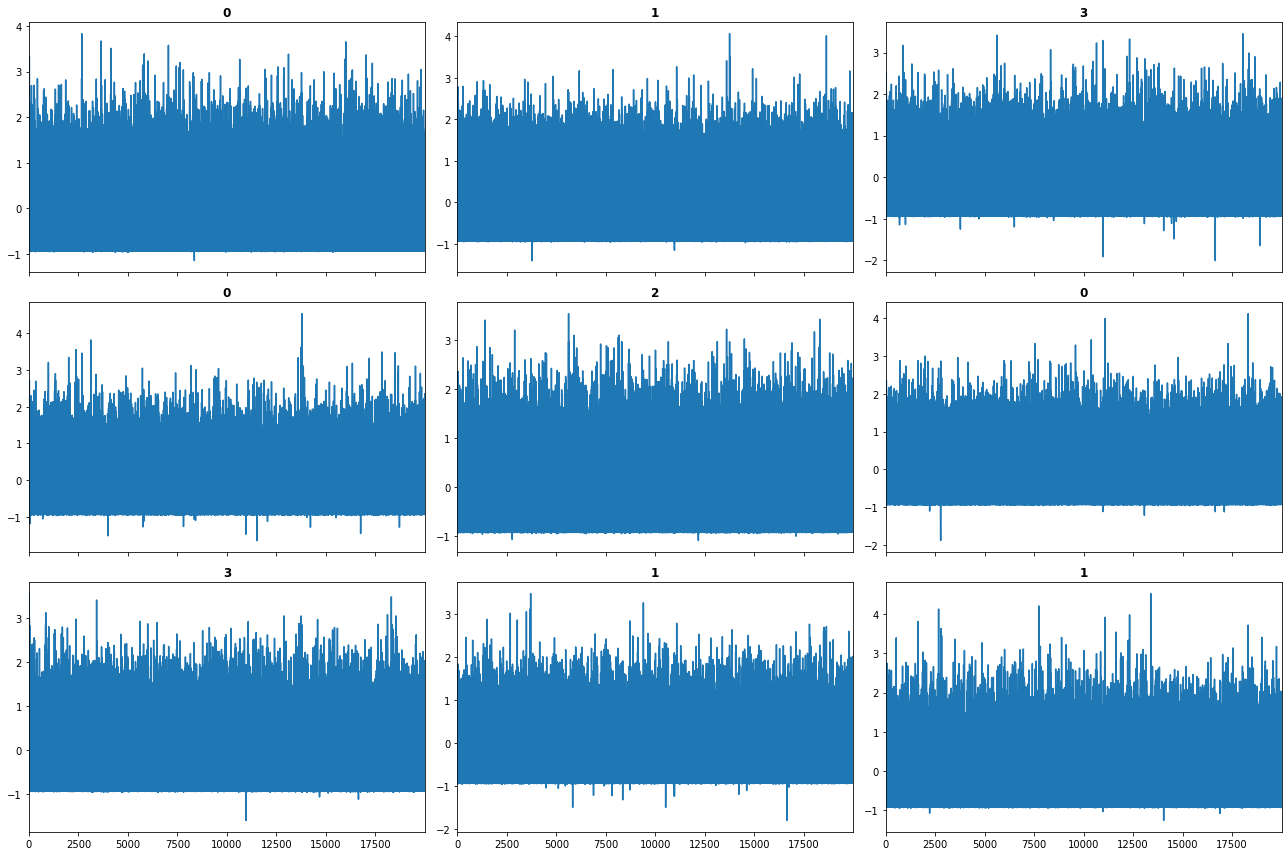

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, batch_tfms=[TSStandardize(by_var=True)])# per feature normalization
dls.show_batch()

In [ ]:
def lin_zero_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.constant_(layer.weight.data, 0.)
        if layer.bias is not None: nn.init.constant_(layer.bias.data, 0.)

epoch,train_loss,valid_loss,accuracy,time
0,1.386294,1.390388,0.189189,00:00
1,1.388322,1.380629,0.189189,00:00
2,1.387084,1.372374,0.405405,00:00
3,1.385692,1.367556,0.391892,00:00
4,1.385801,1.398611,0.202703,00:00
5,1.384942,1.473902,0.202703,00:00
6,1.385203,1.420622,0.216216,00:00
7,1.383171,1.356875,0.405405,00:00
8,1.381003,1.359321,0.405405,00:00
9,1.377475,1.399668,0.189189,00:00


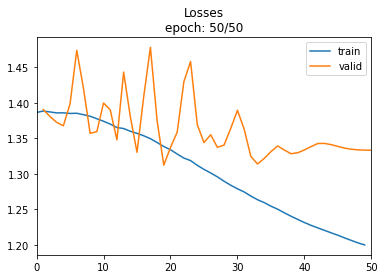

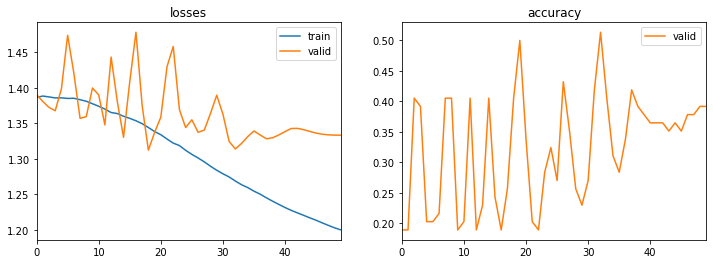

In [ ]:
model = create_mlp_head(dls.vars, dls.c, dls.len)
model.apply(lin_zero_init)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.fit_one_cycle(50, lr_max=1e-4)
learn.plot_metrics()

#### XGBoost

In [ ]:
eps = 1e-6

# normalize 'per feature'
f_mean = X_train.mean(axis=0, keepdims=True)
f_std = X_train.std(axis=0, keepdims=True) + eps
X_train_norm = (X_train - f_mean) / f_std
X_valid_norm = (X_valid - f_mean) / f_std

import xgboost as xgb
classifier = xgb.XGBClassifier(max_depth=3,
                               learning_rate=0.1,
                               n_estimators=100,
                               verbosity=1,
                               objective='binary:logistic',
                               booster='gbtree',
                               tree_method='auto',
                               n_jobs=-1,
                               gpu_id=default_device().index,
                               gamma=0,
                               min_child_weight=1,
                               max_delta_step=0,
                               subsample=.5,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               colsample_bynode=1,
                               reg_alpha=0,
                               reg_lambda=1,
                               scale_pos_weight=1,
                               base_score=0.5,
                               random_state=0,
                               missing=None)

classifier.fit(X_train_norm, y_train)
preds = classifier.predict(X_valid_norm)
(preds == y_valid).mean()

0.3783783783783784

## Conclusions

ROCKET is a great method for TSC that has established a new level of performance both in terms of accuracy and time. It does it by successfully applying an approach quite different from the traditional DL approaches. The method uses 10k random kernels to generate features that are then classified by linear classifiers (although you may use a classifier of your choice).
The original method has 2 limitations (lack of multivariate and lack of GPU support) that are overcome by the Pytorch implementation shared in this notebook.

So this is all the code you need to train a state-of-the-art model using rocket and GPU in `tsai`:

```
X, y, splits = get_UCR_data('HandMovementDirection', return_split=False)
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, drop_last=False, shuffle_train=False, batch_tfms=[TSStandardize(by_sample=True)])
model = create_model(ROCKET, dls=dls)
X_train, y_train = create_rocket_features(dls.train, model)
X_valid, y_valid = create_rocket_features(dls.valid, model)
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train, y_train)
print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
```